# Data Preparation

In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Manage paths
The working directory of the ipykernel must be set to base directory of this repository. All the paths are then defined as relative paths with respect to the base directory

In [2]:
# get the working directory of the ipykernel
working_dir = os.getcwd()

# define subdirectories
data_path = os.path.join(working_dir, "data")

# define files and paths
source_file = "EnergyDF_extended.h5"
source = os.path.join(data_path, source_file)

In [3]:
# Read the entire dataset
df = pd.read_hdf(source)

In [4]:
df

timestamp  actual_main_voltage  actual_robot_voltage  \
sample_nr event                                                         
1         0      21182.840            47.946609             48.005718   
          1      21182.850            47.892868             47.948399   
          2      21182.860            47.926903             47.976166   
          3      21182.870            47.934959             47.983326   
          4      21182.880            47.929588             47.986912   
...                    ...                  ...                   ...   
4094      1745   11648.439            47.901825             47.956459   
          1746   11648.449            47.907200             47.968998   
          1747   11648.459            47.937649             47.989597   
          1748   11648.469            47.905407             47.972580   
          1749   11648.479            47.907200             47.947502   

                 actual_robot_current  output_double_register_25  \
sample_nr event                                                    
1         0                  0.885126                      0.135   
          1                  0.867224                      0.135   
          2                  0.885126                      0.135   
          3                  0.851557                      0.135   
          4                  0.934362                      0.135   
...                               ...                        ...   
4094      1745               0.712797                      0.016   
          1746               0.757556                      0.016   
          1747               0.791126                      0.016   
          1748               0.708320                      0.016   
          1749               0.703849                      0.016   

                 output_bit_register_64  output_bit_register_65  \
sample_nr event                                                   
1         0                       False                   False   
          1                       False                   False   
          2                       False                   False   
          3                       False                   False   
          4                       False                   False   
...                                 ...                     ...   
4094      1745                    False                   False   
          1746                    False                   False   
          1747                    False                   False   
          1748                    False                   False   
          1749                    False                   False   

                 output_bit_register_66  output_bit_register_67  \
sample_nr event                                                   
1         0                       False                   False   
          1                       False                   False   
          2                       False                   False   
          3                       False                   False   
          4                       False                   False   
...                                 ...                     ...   
4094      1745                    False                   False   
          1746                    False                   False   
          1747                    False                   False   
          1748                    False                   False   
          1749                    False                   False   

                 actual_joint_voltage_0  ...  actual_current_3  \
sample_nr event                          ...                     
1         0                   47.713928  ...         -1.007816   
          1                   47.656597  ...         -1.013388   
          2                   47.713928  ...         -1.020771   
          3                   47.685261  ...         -1.026708   
          4                   47.713928  .

## 3.1 Select Data

Ausgelassene Spalten mit Energiebezug:
* Spannungen der Joints (actual_joint_voltage_i)
* Main Voltage
* Robot Voltage
* TODO: Soll-Ströme der Gelenke (target_current_i)
* Control-Ströme der Gelenke (joint_control_output_i)

In [5]:
# Choose columns to keep
keep_columns = ["timestamp",          
                "actual_robot_current",
                "output_double_register_25", # current torque
                "output_bit_register_64", # movement to pin position
                "output_bit_register_65", # movement to home position
                "output_bit_register_66", # Screw loosening
                "output_bit_register_67", # Screw tightening
                    
                # target joint current
                "target_current_0",
                "target_current_1",
                "target_current_2",
                "target_current_3",
                "target_current_4",
                "target_current_5",
                    
                # actual current of the robot's joints
                "actual_current_0",
                "actual_current_1",
                "actual_current_2",
                "actual_current_3",
                "actual_current_4",
                "actual_current_5",
                    
                "label",                 
                ]
    
# Drop unselected columns
df = df[keep_columns]

## 3.2 Clean Data

### Find invalid samples
Find samples, which are either very short or which are irrelevant, redundant, etc.

In [6]:
observations_per_label = df.groupby(["label"]).size()
samples_per_label = df.groupby(["sample_nr", "label"])["label"].size().to_frame(name = "count").groupby("label").size()
avg_observations_per_label = observations_per_label / samples_per_label

sequence_lengths = df.groupby(["sample_nr", "label"])["label"].size().to_frame(name = "count").reset_index()

def peek(nr):
    return sequence_lengths.where((sequence_lengths["sample_nr"] > nr-5) &
                                  (sequence_lengths["sample_nr"] < nr +5)).dropna()

# find out the sequences, which are very short
sequence_lengths.where(sequence_lengths["count"] < 100).dropna()

,sample_nr,label,count
130,131.0,5.0,28.0
143,144.0,5.0,13.0
2378,2379.0,5.0,13.0


In [7]:
# find duplicates
last_label = None
duplicates = list()
for idx, row in sequence_lengths.iterrows():
    label = row["label"]
    if label == last_label:
        duplicates.append(row["sample_nr"])
    last_label = label
duplicates = [d-1 for d in duplicates]
    
print(duplicates)

[131, 1290, 1469, 2154]


In [8]:
# delete duplicates from the dataframe
df.drop(index = duplicates, level = 0, inplace = True, errors = None)

/Users/david/miniforge3/envs/m1tf/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
# summarize the cleaned dataframe
sequence_lengths = df.groupby(["sample_nr", "label"])["label"].size().to_frame(name = "count").reset_index()
sequence_lengths.describe()

,sample_nr,label,count
count,4090.000000,4090.000000,4090.000000
mean,2048.269193,2.806357,1526.807579
std,1182.083065,2.313032,279.920811
min,1.000000,0.000000,13.000000
25%,1024.250000,0.000000,1378.000000
50%,2048.500000,4.500000,1540.000000
75%,3071.750000,5.000000,1733.000000
max,4094.000000,5.000000,3795.000000


### Check time integrity
Find all samples with bad data quality with respect to sequence length or time resolution

Criteria for removal:
1. if more than 0.1ms (i.e. 10 points) between two subsequent rows of the same sample are missing
2. if the average resolution is too small, i.e. if the average time delta exceeds 10% of the expected time delta
3. if the sequence is very short, i.e. it consist of less than 500 points

In [11]:
# define criteria, according to which samples are excluded
max_time_delta = 0.1
max_mean_time_delta = 0.011
min_length = 500

excluded_samples = pd.DataFrame(columns = ["sample_nr", "label", "exclude_criterion"])

time_df = df[["timestamp", "label"]].reset_index(level = 1, drop = True)
print(time_df)

for sample, sub_df in time_df.groupby(level = 0):
    label = sub_df["label"].iloc[0]
    time = sub_df["timestamp"].to_numpy()
    time_delta = np.diff(time)
    
    # first criterion: check if there are missing data points, i.e. check 
    # whether the time delta between two rows exceeds max_time_delta 
    missing_data_points = np.any(time_delta > max_time_delta)
    
    if missing_data_points:
        excluded_sample = pd.Series({"sample_nr": sample, "label": label, "exclude_criterion": 1})
        excluded_samples = excluded_samples.append(excluded_sample, ignore_index = True)
    
    # second criterion: check if the average resolution of the entire sample
    # is not high enough, i.e. if the sample's mean time_delta exceeds 
    # max_mean_time_delta 
    resolution =  np.mean(time_delta)
    insufficient_resolution = resolution > max_mean_time_delta
    
    if missing_data_points:
        excluded_sample = pd.Series({"sample_nr": sample, "label": label, "exclude_criterion": 2}, name = sample)
        excluded_samples = excluded_samples.append(excluded_sample, ignore_index = True)
        
    # third criterion: check if the sub_df (which corresponds to one sample) consists
    # of less than the minimum required length
    
    if len(sub_df) < min_length:
        excluded_sample = pd.Series({"sample_nr": sample, "label": label, "exclude_criterion": 3}, name = sample)
        excluded_samples = excluded_samples.append(excluded_sample, ignore_index = True)

excluded_samples.set_index("sample_nr", inplace=True)
num_excluded_samples = len(excluded_samples.index.unique())
print(f'Number of samples, which match any exclude criterion: {num_excluded_samples}')

           timestamp  label
sample_nr                  
1          21182.840      5
1          21182.850      5
1          21182.860      5
1          21182.870      5
1          21182.880      5
...              ...    ...
4094       11648.439      0
4094       11648.449      0
4094       11648.459      0
4094       11648.469      0
4094       11648.479      0

[6244643 rows x 2 columns]
Number of samples, which match any exclude criterion: 54


In [119]:
excluded_samples

,label,exclude_criterion
sample_nr,,
144,5,3
204,5,1
204,5,2
236,5,1
236,5,2
...,...,...
3947,5,2
3983,5,1
3983,5,2


In case both screwing and unscrewing samples are considered, for every excluded screwing/unscrewing sample we also need to remove its corresponding unscrewing/screwing example: corresponds to exclude_criterion 9

In [120]:
consider_both = True

if consider_both:
    corresponding_samples = list()
    
    for sample, sub_df in excluded_samples.groupby(level = 0):
        
        excluded_sample = None
        label = df.loc[sample]["label"].iloc[0]
        if int(label) > 4:
            # exclude following sample
            label_to_exclude = df.loc[sample+1]["label"].iloc[0]
            excluded_sample = pd.Series({"label": label_to_exclude, "exclude_criterion": 9}, name = sample+1)
        else:
            # exclude the previous sample
            label_to_exclude = df.loc[sample-1]["label"].iloc[0]
            excluded_sample = pd.Series({"label": label_to_exclude, "exclude_criterion": 9}, name = sample-1)
        corresponding_samples.append(excluded_sample)
        
    excluded_samples = excluded_samples.append(corresponding_samples)

    
num_excluded_samples = len(excluded_samples.index.unique())
print(f'Number of samples, which are excluded: {num_excluded_samples}')
excluded_samples

Number of samples, which are excluded: 108


,label,exclude_criterion
144,5,3
204,5,1
204,5,2
236,5,1
236,5,2
...,...,...
3738,0,9
3862,0,9
3948,1,9
3984,0,9


In [133]:
print(excluded_samples.loc[820])
print(excluded_samples[excluded_samples["label"]==4])
excluded_per_label = {0:0,1:0,2:0,3:0,4:0,5:0}
for _, sample in excluded_samples.groupby(level=0):
    label = sample["label"].iloc[0]
    excluded_per_label[label] += 1
excluded_per_label

    label exclude_criterion
820     5                 1
820     5                 2
    label exclude_criterion
821     4                 9


{0: 29, 1: 9, 2: 12, 3: 3, 4: 1, 5: 54}

In [140]:
# finally, drop the excluded samples
df.drop(index = excluded_samples.index.unique(), level = 0, inplace = True, errors = None)

/Users/david/miniforge3/envs/m1tf/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


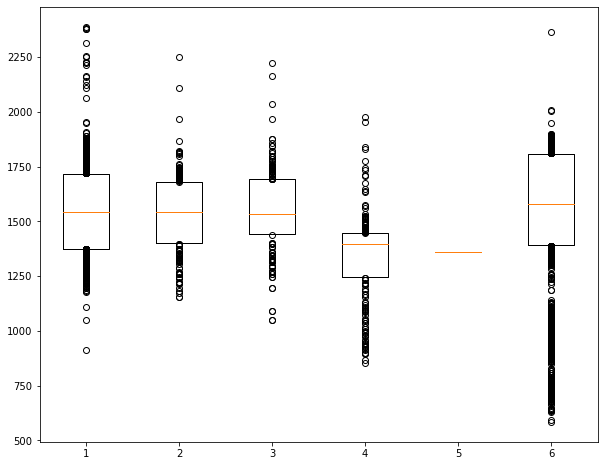

In [142]:
# summarize the cleaned dataframe
sequence_lengths = df.groupby(["sample_nr", "label"])["label"].size().to_frame(name = "sample_length")
sequence_lengths.describe()
sequence_lengths

sample_lengths_per_class = list()
for label, samples in sequence_lengths.groupby(["label"]):
    sample_lengths_per_class.append(samples["sample_length"].to_numpy())
    
fig = plt.figure(figsize=(10,8))
plt.boxplot(sample_lengths_per_class, whis=0)
plt.show()
    

In [13]:
sequence_lengths.where(sequence_lengths["sample_length"] < 600).dropna()

,,sample_length
sample_nr,label,
2909,5,592.0
3319,5,584.0


### Save the cleaned dataset

In [14]:
# Save dataframe
destination = "".join([path, "EnergyDF_clean", ".h5"])
df.to_hdf(destination, key="df")

In [6]:
import gc
gc.collect()

40

In [249]:
excluded_samples

,label,exclude_criterion
144,5,3
2379,5,3
145,5,9
2380,5,9
145,1,9
144,5,9
2380,0,9
2379,5,9
